In [153]:
import numpy
import bokeh.plotting as bplot
bplot.output_notebook()
from matplotlib import pyplot
%matplotlib notebook
from astropy.io import fits

BokehJS successfully loaded.

In [2]:
from soapy import WFS, atmosphere, confParse
from aotools import circle
from aotools.circle import zernike

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/qt.py:13: ShimWarning: The `IPython.qt` package has been deprecated. You should import from qtconsole instead.
  "You should import from qtconsole instead.", ShimWarning)


In [3]:
SOAPY_CONFIG = "conf/test_conf.py"

In [217]:
config = confParse.Configurator(SOAPY_CONFIG)
config.loadSimParams()

config.tel.telDiam = 1.
config.atmos.r0 = 1.
config.atmos.randomScrns = True

config.wfss[0].nxSubaps = 8
config.wfss[0].subapFOV = 6.
config.calcParams()

In [249]:
N_ZERNS = 30
N_ITERS = 10000
IMAT_VALUE = 100
print(config.sim.pxlScale)

128.0


In [219]:
Zs = zernike.zernikeArray(N_ZERNS+1, config.sim.pupilSize, norm='rms')
piston = Zs[0]
Zs = Zs[1:]
pad = config.sim.simPad
Zs = numpy.pad(Zs, ((0,0), (pad, pad), (pad, pad)), mode='constant')

In [220]:
# Setup the WFS
mask = circle.circle(config.sim.pupilSize/2., config.sim.simSize)
wfs = WFS.ShackHartmann(config.sim, config.wfss[0], config.atmos, config.lgss[0], mask)

atmos = atmosphere.atmos(config.sim, config.atmos)

In [221]:
zIMat = numpy.zeros((N_ZERNS, wfs.activeSubaps*2))
# Make the Zernike IMat
for i, z in enumerate(Zs):
    phs = z# * IMAT_VALUE
    zIMat[i] = wfs.frame(phs)#/IMAT_VALUE

<IPython.core.display.Javascript object>


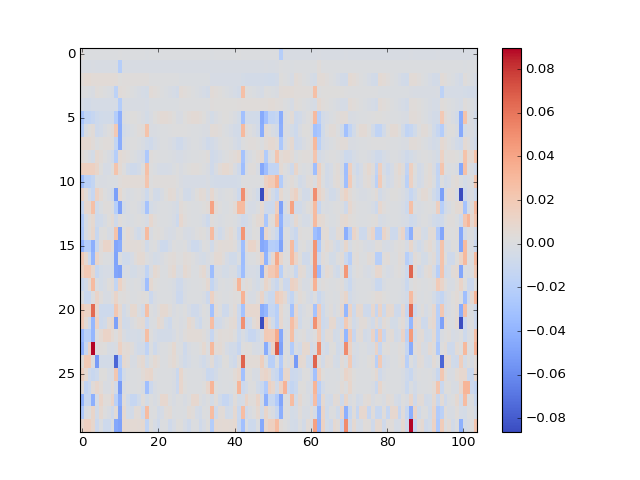

In [222]:
pyplot.figure()
pyplot.imshow(zIMat, aspect='auto')
pyplot.colorbar()

<IPython.core.display.Javascript object>


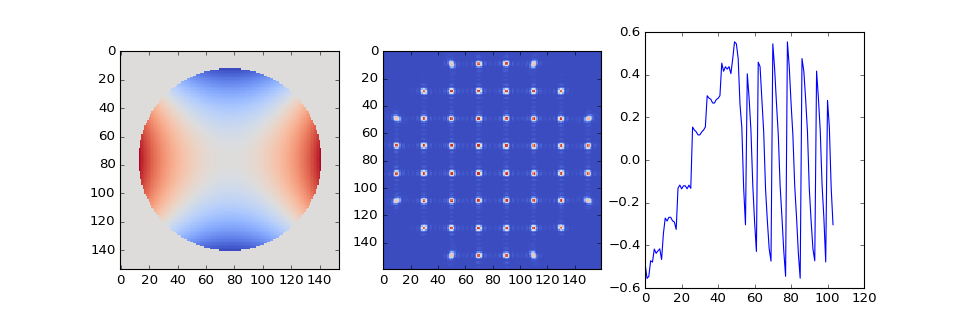

In [223]:
Z = Zs[4]
slopes = wfs.frame(100*Z, iMatFrame=True)
pyplot.figure(figsize=(12, 4))
pyplot.subplot(1,3,1)
pyplot.imshow(Z)
pyplot.subplot(1,3,2)
pyplot.imshow(wfs.wfsDetectorPlane)
pyplot.subplot(1,3,3)
pyplot.plot(slopes)

In [224]:
slopes = numpy.zeros((N_ITERS, 2*wfs.activeSubaps))
for i in range(N_ITERS):
    scrn = atmos.moveScrns()
    slopes[i] = wfs.frame(scrn)

In [225]:
zCMat = numpy.linalg.pinv(zIMat)

In [226]:
zCoeffs = slopes.dot(zCMat)

<IPython.core.display.Javascript object>


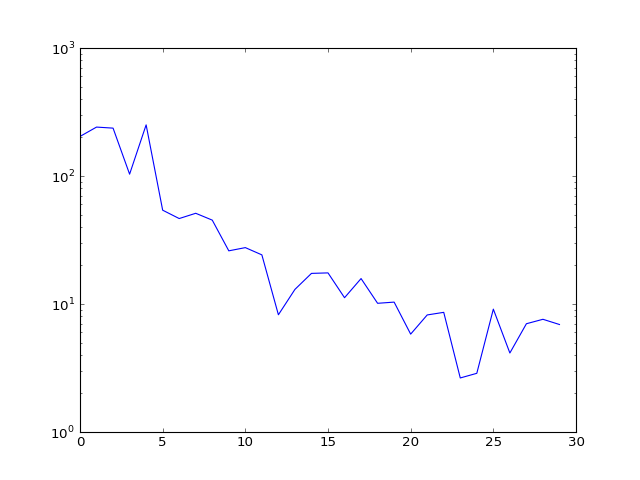

In [227]:
pyplot.figure()
pyplot.semilogy(zCoeffs.var(0))

In [228]:
# Test reconstruction of Zs
reconZCoeffs = numpy.zeros((N_ZERNS, N_ZERNS))
for i, zs in enumerate(zIMat):
    reconZCoeffs[i] = zs.dot(zCMat)

<IPython.core.display.Javascript object>


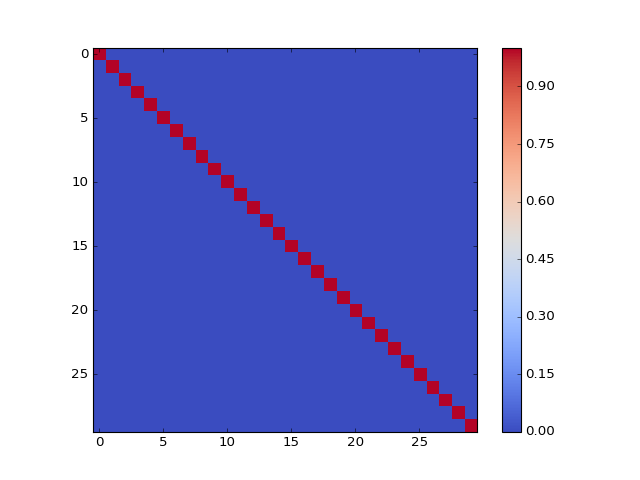

In [229]:
pyplot.figure()
pyplot.imshow(reconZCoeffs)
pyplot.colorbar()

In [230]:
# Load the reference noll values
noll = fits.getdata("resources/noll.fits").diagonal()[:N_ZERNS]

<IPython.core.display.Javascript object>


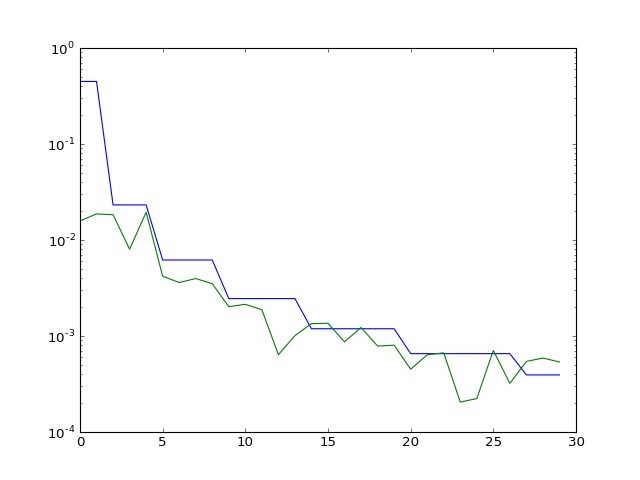

In [231]:
pyplot.figure()
pyplot.semilogy(noll)
pyplot.semilogy(zCoeffs.var(0)/piston.sum())

In [207]:
(zCoeffs.var(0)[2:]/noll[2:]).mean()

3801.4745013699389

# Now test for a range of r0 values

In [232]:
R0s = numpy.linspace(0.05, 1, 10)

In [245]:
slopes = numpy.zeros((len(R0s), N_ITERS, 2*wfs.activeSubaps))
for ir0, r0 in enumerate(R0s):
    print('test r0:{}'.format(r0))
    config.atmos.r0 = r0
    atmos = atmosphere.atmos(config.sim, config.atmos)
    for i in range(N_ITERS):
        scrn = atmos.moveScrns()
        slopes[ir0, i] = wfs.frame(scrn)

test r0:0.05
test r0:0.155555555556
test r0:0.261111111111
test r0:0.366666666667
test r0:0.472222222222
test r0:0.577777777778
test r0:0.683333333333
test r0:0.788888888889
test r0:0.894444444444
test r0:1.0


In [250]:
zCoeffs = numpy.zeros((len(R0s), N_ITERS, N_ZERNS))
for ir0 in range(len(R0s)):
        zCoeffs[ir0] = slopes[ir0].dot(zCMat)

<IPython.core.display.Javascript object>


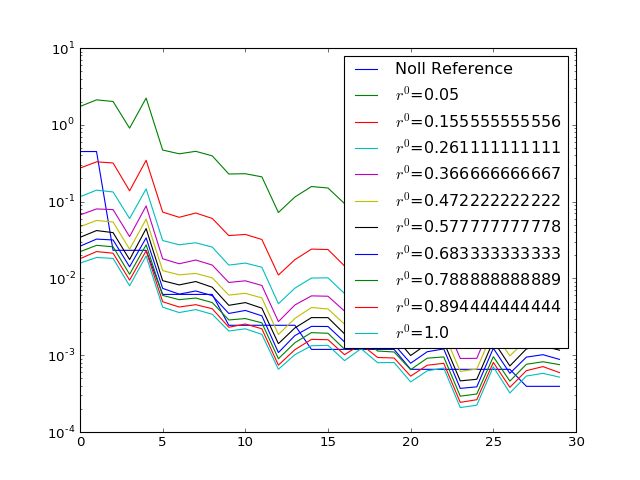

In [251]:
pyplot.figure()
pyplot.semilogy(noll, label='Noll Reference')
for ir0, r0 in enumerate(R0s):
    pyplot.semilogy(zCoeffs[ir0].var(0)/piston.sum(), label='$r^0$={}'.format(r0))
pyplot.legend(loc=0)

In [ ]:
measuredR0s = numpy.zeros_like(R0s)
for ir0 in range(len(R0s)):
    